In [4]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.signal import stft, windows
from skimage.transform import downscale_local_mean

# Raw list of complex numbers where the complex part ends in "i".
raw_data: DataFrame = pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)

# Map the raw data into a numpy array of complex numbers.
# 
# The "i" in each row must be replaced with "j" because Python uses the engineering convention for
# representing complex numbers.
data: np.ndarray[complex] = raw_data.map(lambda row: np.csingle(row.replace("i", "j")))[0]

data = data[:]

# Sampling frequency
fs = 20000000  # Hz

# Calculate Short Time Fourier Transform of the signal.
# return_one_sided is needed because the data is complex
f, t, Sxx = stft(x=data, fs=fs, return_onesided=False)

f += 2447000000

# A spectrogram is the absolute value of the STFT and then squared.
Sxx_abs = (np.abs(Sxx) ** 2)
print(Sxx_abs.shape)

(256, 7814)


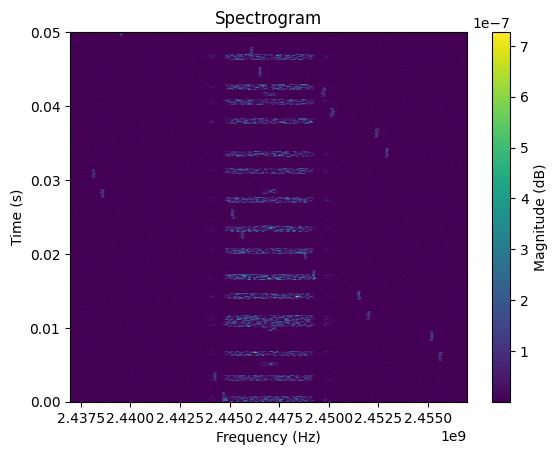

In [11]:
# To plot with 'nearest' shading the data must be monotonically
# increasing/decreasing in value. For some reason our spectrogram
# has the negative frequencies in the *last* half of the data so here
# it is moved to the front
f = np.concatenate((f[len(f) // 2:], f[:len(f) // 2]))
Sxx_abs = np.concatenate((Sxx_abs[len(Sxx_abs) // 2:], Sxx_abs[:len(Sxx_abs) // 2]))

l = len(Sxx_abs)
# middle: int = l // 2
# start: int = middle - 30
# end: int = middle + 30
# f = f[start:end]
# Sxx_abs = Sxx_abs[start:end]

# Plot spectrogram
# Pass frequencies and time values for the X, Y values for the color mesh.
plt.pcolormesh(f, t, np.clip(Sxx_abs, 0, 0.00007).T, shading="nearest")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Time (s)")
plt.title("Spectrogram")
plt.colorbar(label="Magnitude (dB)")
plt.show()

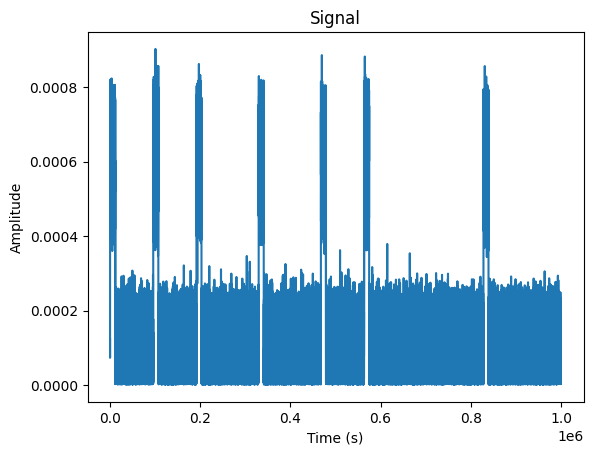

In [201]:
plt.plot(np.abs(data))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal")
plt.show()

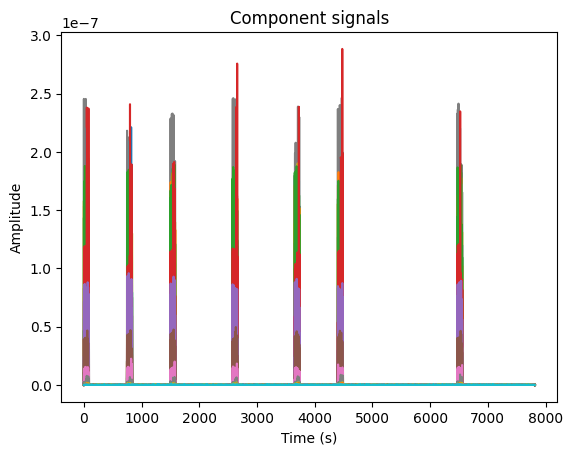

In [202]:
plt.plot(Sxx_abs.T)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Component signals")
plt.show()

In [203]:
def downsample(spectrogram, resolution: int):
    """
    Downsample a spectrogram to a target N x N resolution.
    
    :param spectrogram: A 2D array of a spectrogram. 
    :arg resolution: The target height/width of the image in pixels.
    :return: The downsampled spectrogram.
    """
    time_factor = len(t) // resolution
    freq_factor = len(f) // resolution
    downsampled_spectrogram = downscale_local_mean(spectrogram, (freq_factor, time_factor))[:resolution, :resolution]

    assert downsampled_spectrogram.shape == (resolution, resolution)
    return downsampled_spectrogram


target_resolution = 128
downsampled = downsample(Sxx_abs, target_resolution)
plt.pcolormesh(np.arange(target_resolution), np.arange(target_resolution), downsampled.T,
               shading="nearest")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Time (s)")
plt.title("Spectrogram")
plt.colorbar(label="Magnitude (dB)")
plt.show()

ValueError: Down-sampling factors must be >= 1. Use `skimage.transform.resize` to up-sample an image.

In [ ]:
def augment(spectrogram, K: int, L: int, D: int) -> np.ndarray:
    """
    Augment the Bluetooth and Zigbee signals by stretching them.

    :param spectrogram: An M x N array of signal magnitude values. 
    :param K: The number of maximum values
    :param L: The sliding window size
    :param D: The step size
    """

    # copy the spectrogram so modifying the values in-place
    # does not change the argument.
    spectrogram_copy = np.copy(spectrogram).T
    (M, N) = spectrogram_copy.shape

    augmented_width = (N - L) // D + 1
    augmented_spectrogram: np.ndarray = np.zeros(shape=(M, augmented_width), dtype=float)

    m = np.mean(spectrogram_copy)

    for i in range(1, M):
        j_augmented = 0
        j = 0
        while j <= N - L:
            # For the current row i, get a window of size L.
            window = spectrogram_copy[i][j:(j + L)]
            # Get the top K elements by sorting and taking last K elements.
            top_k = np.sort(window)[len(window) - K:]
            mean_top_k = np.mean(top_k)
            spectrogram_copy[i][j] = mean_top_k
            augmented_spectrogram[i][j_augmented] = spectrogram_copy[i][j] - m

            j_augmented += 1
            j += D

    return augmented_spectrogram


def plot_spectrogram(spectrogram):
    (n_t, n_f) = spectrogram.shape

    plt.pcolormesh(np.arange(n_f), np.arange(n_t), spectrogram, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Augmented spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()


plot_spectrogram(spectrogram=augment(spectrogram=downsampled, K=3, L=16, D=4))


In [ ]:
def paint_spectrogram(original: np.ndarray, augmented: np.ndarray) -> np.ndarray:
    painted_spectrogram: np.ndarray = np.zeros(shape=augmented.shape, dtype=float)
    mean_original_rows = np.mean(original, axis=0)

    for i in range(len(augmented)):
        painted_spectrogram[i] = augmented[i] - mean_original_rows[i]

    return np.clip(painted_spectrogram, 0, 1)


painted = paint_spectrogram(original=downsampled, augmented=augment(spectrogram=downsampled, K=3, L=16, D=4))
plot_spectrogram(spectrogram=painted)

plt.plot(np.mean(downsampled, axis=0))

In [ ]:
def normalize_spectrogram(spectrogram: np.ndarray) -> np.ndarray:
    """
    
    :param spectrogram: 
    :return: 
    """
    scale: float = 1 / spectrogram.max()
    return spectrogram * scale


plt.imshow(normalize_spectrogram(painted))
plt.show()
